<a href="https://colab.research.google.com/github/tanuja1708/EEG-emotions/blob/main/seed4%20all%20methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scipy numpy PyWavelet scikit-learn pykalman


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import scipy.io
import pywt
from sklearn.decomposition import PCA
from scipy.signal import butter, filtfilt, welch
from pykalman import KalmanFilter
import pandas as pd

# --- Settings ---
mat_file_path = '/content/1_20160518.mat'  # Your actual .mat file
sampling_rate_original = 2500
sampling_rate_final = 200
wavelet = 'db4'
wavelet_level = 4

# EEG emotion labels for cz_eeg1 to cz_eeg24
labels = [1, 2, 3, 0, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 2, 3, 2, 2, 3, 3, 0, 3, 0, 3]

# Frequency bands (Hz)
freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 14),
    "Beta": (14, 31),
    "Gamma": (31, 50)
}

# Kalman Filter setup
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.2 * np.eye(1),
    observation_covariance=0.5 * np.eye(1),
    initial_state_mean=[20],
    initial_state_covariance=5 * np.eye(1)
)

# --- Helper Functions ---
def bandpass_filter(data, lowcut, highcut, fs):
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

def downsample(signal, original_fs, target_fs):
    factor = int(original_fs / target_fs)
    return signal[::factor]

def mspca_denoise(eeg_data, wavelet='db4', level=4):
    denoised_eeg = []
    for channel in eeg_data:
        coeffs = pywt.wavedec(channel, wavelet, level=level)
        denoised_coeffs = []
        for c in coeffs:
            if len(c) > 1:
                c = c.reshape(-1, 1)
                pca = PCA(n_components=1)
                transformed = pca.fit_transform(c)
                reconstructed = pca.inverse_transform(transformed).flatten()
                denoised_coeffs.append(reconstructed)
            else:
                denoised_coeffs.append(c)
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
        denoised_eeg.append(denoised_signal[:len(channel)])
    return np.array(denoised_eeg)

def extract_de_lds(eeg_data):
    eeg_data = [downsample(ch, sampling_rate_original, sampling_rate_final) for ch in eeg_data]
    eeg_data = [bandpass_filter(ch, 1, 50, sampling_rate_final) for ch in eeg_data]
    eeg_data = mspca_denoise(np.array(eeg_data))

    de_features = []
    for ch_data in eeg_data:
        freqs, psd = welch(ch_data, fs=sampling_rate_final, nperseg=200)
        band_de = []
        for _, (low, high) in freq_bands.items():
            band_power = psd[(freqs >= low) & (freqs <= high)]
            band_de_value = 0.5 * np.log(2 * np.pi * np.e * (np.mean(band_power) + 1e-6))
            band_de.append(band_de_value)
        smoothed_de, _ = kf.filter(np.array(band_de).reshape(-1, 1))
        de_features.append(smoothed_de.flatten())
    de_features = np.array(de_features)

    # # Normalize to 15–27
    # de_min, de_max = np.min(de_features), np.max(de_features)
    # scaled = 15 + (de_features - de_min) / (de_max - de_min + 1e-8) * (27 - 15)
    return de_features.flatten()

# --- Load the .mat file ---
mat = scipy.io.loadmat(mat_file_path)

# Extract keys like cz_eeg1 to cz_eeg24
all_features = []
for i in range(1, 25):
    key = f'cz_eeg{i}'
    eeg_data = mat[key]  # shape: (channels, time)
    features = extract_de_lds(eeg_data)
    all_features.append(features)

# Combine features and labels
processed_features = np.array(all_features)
labels = np.array(labels)
data_with_labels = np.hstack((processed_features, labels.reshape(-1, 1)))

# Save to CSV
column_names = [f'feature_{i+1}' for i in range(processed_features.shape[1])] + ['label']
df = pd.DataFrame(data_with_labels, columns=column_names)
df.to_csv('seed4_processed_from_single_mat.csv', index=False)
print("✅ Saved to seed4_processed_from_single_mat.csv")


✅ Saved to seed4_processed_from_single_mat.csv


In [4]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Attention, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
import pickle


In [9]:
df = pd.read_csv('/content/seed4_final.csv')

# Features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=4)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape: (samples, 62 timesteps, 5 features)
X_reshaped = X_scaled.reshape(-1, 62, 5)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(288, 62, 5)
(288, 4)
(72, 62, 5)
(72, 4)


In [10]:
def build_generator(latent_dim, num_classes):
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(num_classes,))
    merged = Concatenate()([noise_input, label_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(62 * 5, activation='tanh')(x)
    x = tf.keras.layers.Reshape((62, 5))(x)
    return Model([noise_input, label_input], x)


def build_discriminator(input_shape, num_classes):
    data_input = Input(shape=input_shape)
    label_input = Input(shape=(num_classes,))
    x = tf.keras.layers.Flatten()(data_input)
    merged = Concatenate()([x, label_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(1, activation='sigmoid')(x)
    return Model([data_input, label_input], x)


latent_dim = 100
num_classes = 4
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator((62, 5), num_classes)
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# Combined GAN
discriminator.trainable = False
noise_input = Input(shape=(latent_dim,))
label_input = Input(shape=(num_classes,))
generated_sample = generator([noise_input, label_input])
validity = discriminator([generated_sample, label_input])
cgan = Model([noise_input, label_input], validity)
cgan.compile(optimizer='adam', loss='binary_crossentropy')

In [11]:
def train_gan(epochs=5000, batch_size=64):
    for epoch in range(epochs):

        discriminator.trainable = True

        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_samples = X_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict([noise, real_labels])

        real_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch([real_samples, real_labels], real_y)
        d_loss_fake = discriminator.train_on_batch([fake_samples, real_labels], fake_y)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = cgan.train_on_batch([noise, real_labels], real_y)

        if epoch % 500 == 0:
            print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
train_gan(epochs=5000)

Streaming output truncated to the last 5000 lines.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

In [12]:
def generate_synthetic_samples(n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    random_classes = np.random.randint(0, num_classes, n_samples)
    labels_categorical = to_categorical(random_classes, num_classes=num_classes)
    synthetic_data = generator.predict([noise, labels_categorical])
    return synthetic_data, labels_categorical

synthetic_X, synthetic_y = generate_synthetic_samples(10000)

# Combine real + synthetic
X_combined = np.concatenate((X_train, synthetic_X), axis=0)
y_combined = np.concatenate((y_train, synthetic_y), axis=0)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [13]:
from collections import Counter
import numpy as np

# Convert one-hot encoded labels back to integer indices
train_labels = np.argmax(y_combined, axis=1)

# Decode class indices to label names
label_names = le.inverse_transform(np.arange(len(le.classes_)))

# Count occurrences
class_counts = Counter(train_labels)

# Display counts with emotion names
for idx in sorted(class_counts.keys()):
    print(f"{label_names[idx]}: {class_counts[idx]} samples")

0.0: 2583 samples
1.0: 2555 samples
2.0: 2555 samples
3.0: 2595 samples


In [14]:

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_combined.shape)
print(y_combined.shape)

(288, 62, 5)
(288, 4)
(72, 62, 5)
(72, 4)
(10288, 62, 5)
(10288, 4)


In [19]:
#without gan
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_combined, y_train_combined)).shuffle(1000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_combined, y_test_combined)).batch(batch_size)



model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(62, 5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 7 emotions
])



model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# history = model.fit(
#     train_dataset,
#     epochs=100,
#     validation_data=test_dataset
# )
history1 = model.fit(
    train_dataset,
    epochs=100,
    validation_data=test_dataset
)

# Evaluate accuracy
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy after 50 epochs: {test_acc:.4f}")

# Save the model
model.save('emotion_model_50_epochs.h5')



Epoch 1/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6881 - loss: 0.7448 - val_accuracy: 0.8470 - val_loss: 0.4104
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8600 - loss: 0.3839 - val_accuracy: 0.9078 - val_loss: 0.2450
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8984 - loss: 0.2741 - val_accuracy: 0.9199 - val_loss: 0.2203
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9149 - loss: 0.2267 - val_accuracy: 0.9324 - val_loss: 0.1983
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9234 - loss: 0.1989 - val_accuracy: 0.9281 - val_loss: 0.1983
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9336 - loss: 0.1716 - val_accuracy: 0.9503 - val_loss: 0.1498
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9392 - loss: 0.1586 - val_accuracy: 0.9392 - val_loss: 0.1672
Epoch 8/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9485 - loss: 0.1409 -

Test Accuracy after 50 epochs: 0.9855


In [20]:
with open('eeg_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [17]:
from sklearn.model_selection import train_test_split

synthetic_X_train, synthetic_X_test, synthetic_y_train, synthetic_y_test = train_test_split(
    synthetic_X, synthetic_y, test_size=0.2, random_state=42
)

# Combine synthetic + real for training
X_train_combined = np.concatenate((X_train, synthetic_X_train), axis=0)
y_train_combined = np.concatenate((y_train, synthetic_y_train), axis=0)

# Combine synthetic + real for testing
X_test_combined = np.concatenate((X_test, synthetic_X_test), axis=0)
y_test_combined = np.concatenate((y_test, synthetic_y_test), axis=0)

# Final shapes
print("Final train shape:", X_train_combined.shape, y_train_combined.shape)
print("Final test shape:", X_test_combined.shape, y_test_combined.shape)

Final train shape: (8288, 62, 5) (8288, 4)
Final test shape: (2072, 62, 5) (2072, 4)


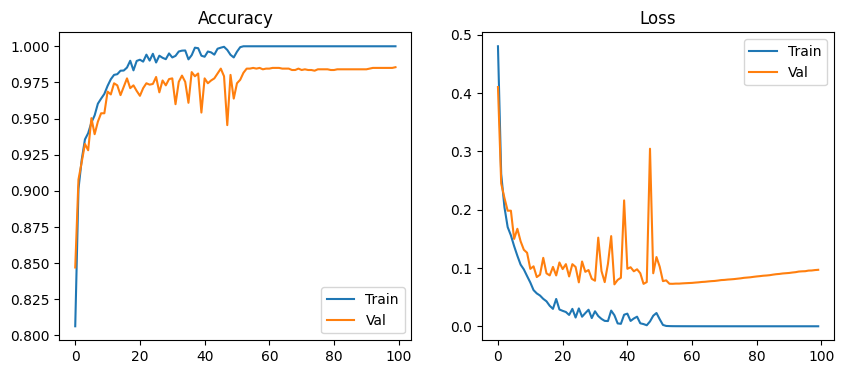

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train')
plt.plot(history1.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train')
plt.plot(history1.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       513
         1.0       0.99      0.98      0.99       494
         2.0       0.97      0.99      0.98       544
         3.0       0.98      0.98      0.98       521

    accuracy                           0.99      2072
   macro avg       0.99      0.99      0.99      2072
weighted avg       0.99      0.99      0.99      2072



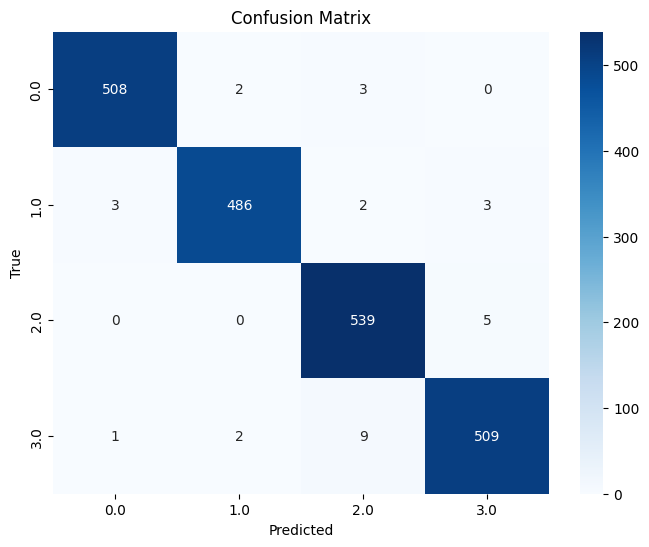

In [25]:
#50 epochs
y_pred = model.predict(X_test_combined)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_combined, axis=1)

# Convert le.classes_ to strings
target_names = [str(cls) for cls in le.classes_]

print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=target_names))
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()